# Treating COVID-19 Lockdowns as One-Off Holidays

This example is taken directly from the Prophet documentation:
https://facebook.github.io/prophet/docs/handling_shocks.html#treating-covid-19-lockdowns-as-a-one-off-holidays

We'll use real pedestrian count data from Melbourne, Australia during the COVID-19 period.

In [8]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

## Load the data

Load pedestrian count data from Melbourne, Australia.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_pedestrians_covid.csv')
df['ds'] = pd.to_datetime(df['ds'])
df.head()

## Comparison: Before and After Adding Holidays

First, let's fit a baseline model WITHOUT the lockdown holidays to see how it performs.

In [17]:
# Baseline model WITHOUT lockdowns
m_baseline = Prophet()
m_baseline.fit(df)

future_baseline = m_baseline.make_future_dataframe(periods=365*3)
forecast_baseline = m_baseline.predict(future_baseline)

11:26:19 - cmdstanpy - INFO - Chain [1] start processing
11:26:19 - cmdstanpy - INFO - Chain [1] done processing


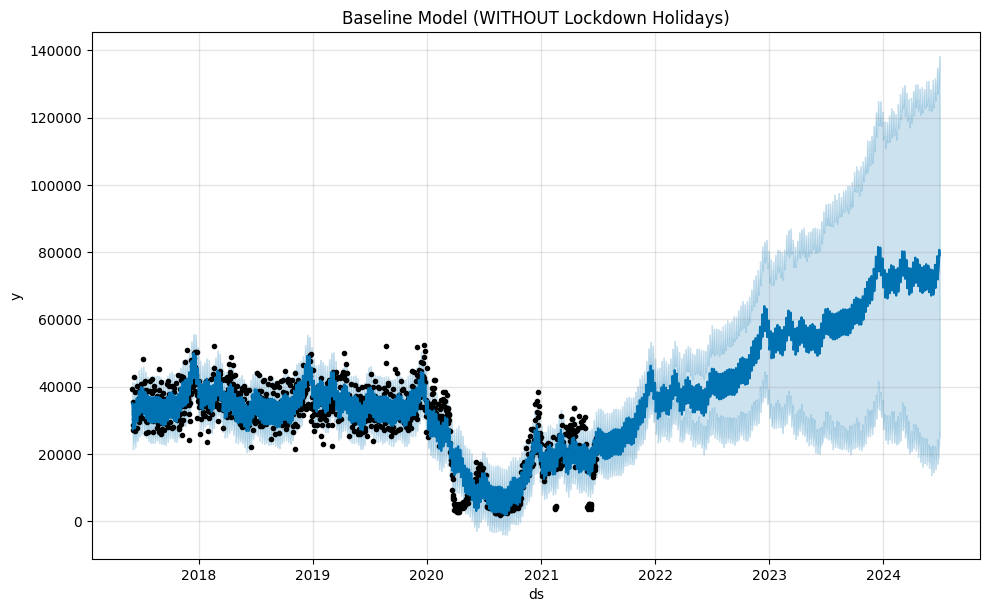

In [18]:
# Plot baseline forecast
fig = m_baseline.plot(forecast_baseline)
plt.title('Baseline Model (WITHOUT Lockdown Holidays)')
plt.show()

## Define lockdown periods

We define the lockdown periods in Melbourne as one-off holidays. Each lockdown is specified with a start date (`ds`), and we use `ds_upper` to specify when it ended. The `upper_window` will be computed as the number of days between `ds` and `ds_upper`.

In [12]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-30', 'lower_window': 0, 'ds_upper': '2020-05-12'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-08', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-12', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-27', 'lower_window': 0, 'ds_upper': '2021-06-10'},
    {'holiday': 'lockdown_5', 'ds': '2021-07-15', 'lower_window': 0, 'ds_upper': '2021-07-27'},
    {'holiday': 'lockdown_6', 'ds': '2021-08-05', 'lower_window': 0, 'ds_upper': '2021-10-21'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-30,0,2020-05-12,43
1,lockdown_2,2020-07-08,0,2020-10-27,111
2,lockdown_3,2021-02-12,0,2021-02-17,5
3,lockdown_4,2021-05-27,0,2021-06-10,14
4,lockdown_5,2021-07-15,0,2021-07-27,12
5,lockdown_6,2021-08-05,0,2021-10-21,77


## Fit the model

We pass the lockdowns DataFrame to the Prophet model as the `holidays` parameter.

In [13]:
m = Prophet(holidays=lockdowns)
m.fit(df)

11:25:29 - cmdstanpy - INFO - Chain [1] start processing
11:25:30 - cmdstanpy - INFO - Chain [1] done processing


## Make predictions

In [19]:
future = m.make_future_dataframe(periods=365*3)
forecast = m.predict(future)

## Plot the forecast

## Side-by-Side Comparison

Let's compare the two models side by side to see the impact of including lockdown holidays.

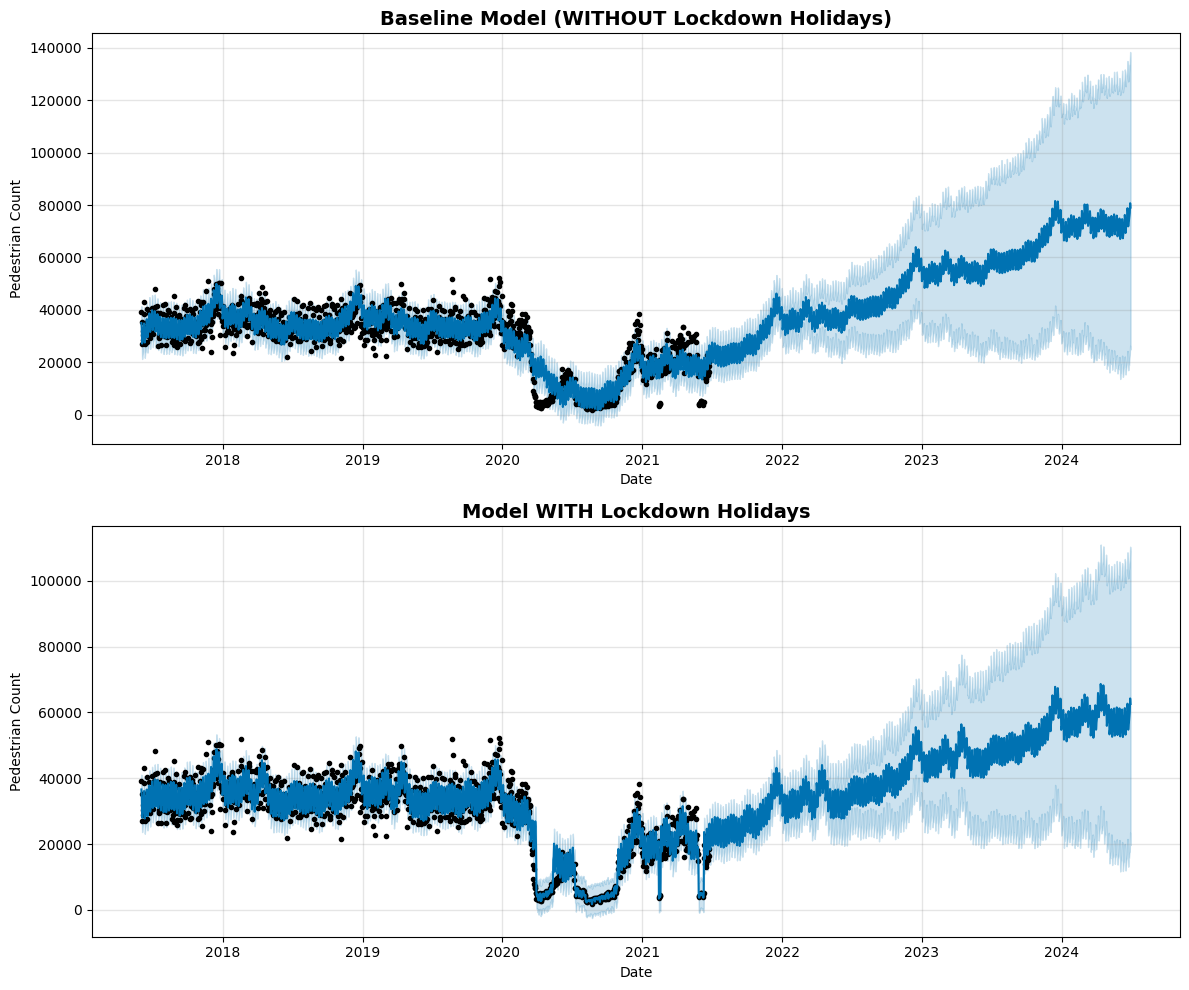

In [20]:
# Create side-by-side comparison
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot baseline model
m_baseline.plot(forecast_baseline, ax=axes[0])
axes[0].set_title('Baseline Model (WITHOUT Lockdown Holidays)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Pedestrian Count')

# Plot model with holidays
m.plot(forecast, ax=axes[1])
axes[1].set_title('Model WITH Lockdown Holidays', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Pedestrian Count')

plt.tight_layout()
plt.show()

## Overlay Comparison

Another way to visualize the difference is to overlay both forecasts on the same plot.

/tmp/ipykernel_27773/648287973.py:8: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(forecast_baseline['ds'], forecast_baseline['yhat'],


TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x7c8e3257b4d0>.

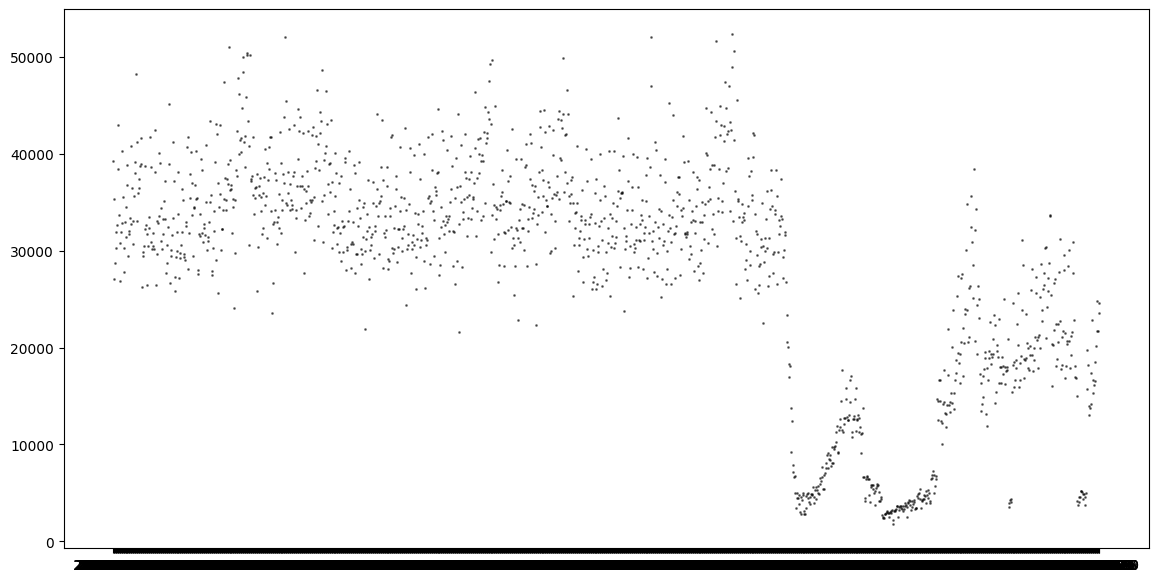

In [21]:
# Overlay comparison
fig, ax = plt.subplots(figsize=(14, 7))

# Plot actual data
ax.plot(df['ds'], df['y'], 'k.', markersize=2, alpha=0.5, label='Actual')

# Plot baseline forecast
ax.plot(forecast_baseline['ds'], forecast_baseline['yhat'], 
        color='blue', linewidth=2, alpha=0.7, label='Baseline (no holidays)')
ax.fill_between(forecast_baseline['ds'], 
                forecast_baseline['yhat_lower'], 
                forecast_baseline['yhat_upper'], 
                color='blue', alpha=0.2)

# Plot forecast with holidays
ax.plot(forecast['ds'], forecast['yhat'], 
        color='red', linewidth=2, alpha=0.7, label='With lockdown holidays')
ax.fill_between(forecast['ds'], 
                forecast['yhat_lower'], 
                forecast['yhat_upper'], 
                color='red', alpha=0.2)

# Add vertical lines for lockdowns
for idx, row in lockdowns.iterrows():
    ax.axvspan(row['ds'], row['ds_upper'], alpha=0.1, color='gray')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Pedestrian Count', fontsize=12)
ax.set_title('Comparison: Baseline vs Model with Lockdown Holidays', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Observations

When comparing the two models:

1. **Baseline Model (without holidays)**: Struggles to capture the sudden drops during lockdown periods. It tries to fit the trend and seasonality but cannot explain the dramatic decreases in pedestrian traffic.

2. **Model with Lockdown Holidays**: Explicitly models the lockdown periods as special events, leading to:
   - Better fit during lockdown periods
   - More accurate uncertainty intervals
   - Better future predictions that don't incorrectly assume lockdowns will repeat

3. **Lockdown Effects**: The component plot shows how each lockdown period affected pedestrian counts, with varying magnitudes depending on the severity and duration of restrictions.

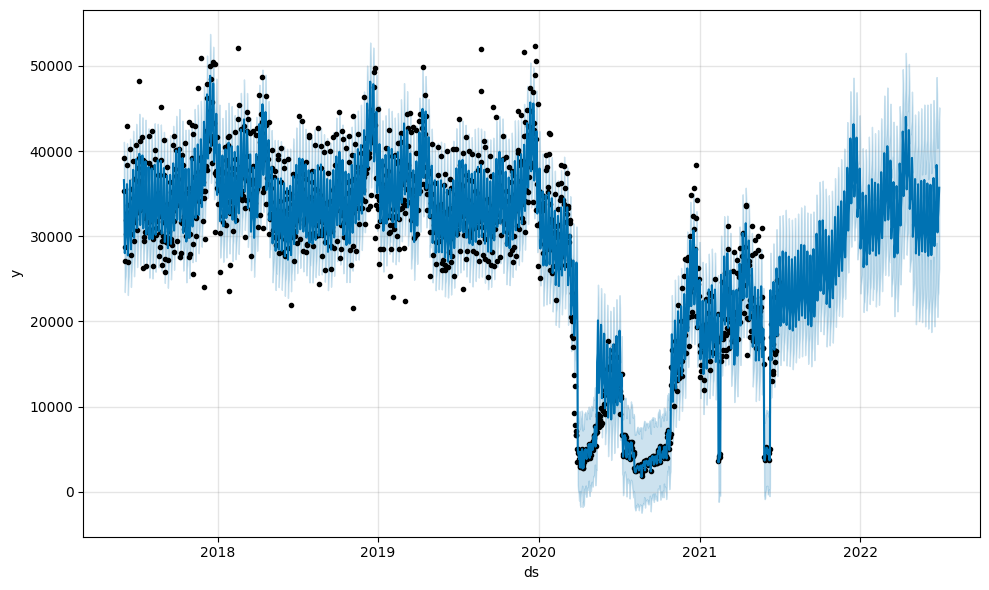

In [6]:
fig = m.plot(forecast)

## Plot components

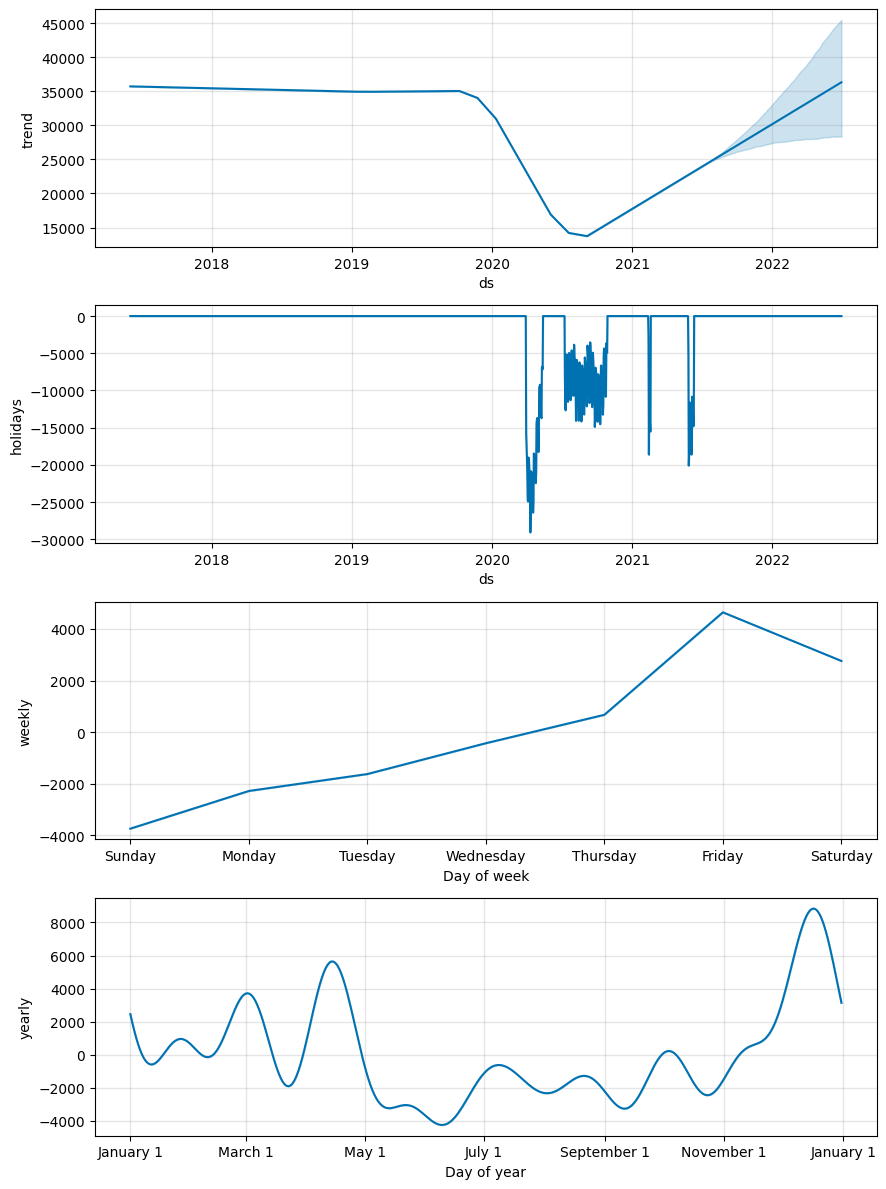

In [7]:
fig = m.plot_components(forecast)